### Zhuyu Chen Su
** RA: 10400811 **

In [ ]:
import json
import pandas as pd

# Carregando os discursos do arquivo JSON
with open("Discursos_PLs_Novo_Ensino_Medio_01.json", "r", encoding="utf-8") as file:
    dados = json.load(file)

df_discursos = pd.DataFrame(dados["data"])
df_discursos.dropna(subset=["sumario"], inplace=True)  # Remove discursos vazios


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Carregando o modelo BERT pré-treinado
modelo = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(modelo)
model = AutoModel.from_pretrained(modelo)

# Tokenizar todos os discursos e criar tensores
tokens = tokenizer(
    list(df_discursos["sumario"]),
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=512
)

In [ ]:
# Gerar embeddings usando o modelo BERT
with torch.no_grad():
    outputs = model(**tokens)

# Usamos a média da última camada oculta
embeddings_discursos = outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Adicionamos os embeddings ao DataFrame
df_discursos["embedding"] = embeddings_discursos.tolist()

In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity


# --- Função para dividir em blocos com limite de tokens ---
def dividir_em_blocos(texto, tokenizer, max_tokens=512):
    tokens = tokenizer.tokenize(texto)
    blocos = [tokens[i:i+max_tokens] for i in range(0, len(tokens), max_tokens)]
    return [" ".join(tokenizer.convert_tokens_to_string(b).split()) for b in blocos]

# Função para gerar o embedding médio dos blocos
def gerar_embedding_medio(texto, tokenizer, model):
    blocos = dividir_em_blocos(texto, tokenizer)
    embeddings = []

    for bloco in blocos:
        inputs = tokenizer(bloco, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
        embeddings.append(embedding)

    media = torch.stack(embeddings).mean(dim=0)
    return media.numpy()

# Texto da lei a ser pré-processado e convertido em embedding

texto_lei = """
LEI Nº 13.415, DE 16 DE FEVEREIRO DE 2017
Art. 1º O art. 24 da Lei nº 9.394, de 20 de dezembro de 1996, passa a vigorar com as seguintes alterações: 
 
"Art. 24. 
I - a carga horária mínima anual será de oitocentas horas para o ensino fundamental e para o ensino médio, distribuídas por um mínimo de duzentos dias de efetivo trabalho escolar, excluído o tempo reservado aos exames finais, quando houver;
  
§ 1º A carga horária mínima anual de que trata o inciso I do caput deverá ser ampliada de forma progressiva, no ensino médio, para mil e quatrocentas horas, devendo os sistemas de ensino oferecer, no prazo máximo de cinco anos, pelo menos mil horas anuais de carga horária, a partir de 2 de março de 2017. 
§ 2º Os sistemas de ensino disporão sobre a oferta de educação de jovens e adultos e de ensino noturno regular, adequado às condições do educando, conforme o inciso VI do art. 4º." (NR)
 
Art. 2º O art. 26 da Lei nº 9.394, de 20 de dezembro de 1996, passa a vigorar com as seguintes alterações: 
 
"Art. 26. 
§ 2º O ensino da arte, especialmente em suas expressões regionais, constituirá componente curricular obrigatório da educação básica. 
§ 5º No currículo do ensino fundamental, a partir do sexto ano, será ofertada a língua inglesa. 
§ 7º A integralização curricular poderá incluir, a critério dos sistemas de ensino, projetos e pesquisas envolvendo os temas transversais de que trata o caput.
§ 10. A inclusão de novos componentes curriculares de caráter obrigatório na Base Nacional Comum Curricular dependerá de aprovação do Conselho Nacional de Educação e de homologação pelo Ministro de Estado da Educação." (NR)
 
Art. 3º A Lei nº 9.394, de 20 de dezembro de 1996, passa a vigorar acrescida do seguinte art. 35-A: 
 
"Art. 35-A. A Base Nacional Comum Curricular definirá direitos e objetivos de aprendizagem do ensino médio, conforme diretrizes do Conselho Nacional de Educação, nas seguintes áreas do conhecimento: 
I - linguagens e suas tecnologias; 
II - matemática e suas tecnologias; 
III - ciências da natureza e suas tecnologias; 
IV - ciências humanas e sociais aplicadas. 
§ 1º A parte diversificada dos currículos de que trata o caput do art. 26, definida em cada sistema de ensino, deverá estar harmonizada à Base Nacional Comum Curricular e ser articulada a partir do contexto histórico, econômico, social, ambiental e cultural. 
§ 2º A Base Nacional Comum Curricular referente ao ensino médio incluirá obrigatoriamente estudos e práticas de educação física, arte, sociologia e filosofia. 
§ 3º O ensino da língua portuguesa e da matemática será obrigatório nos três anos do ensino médio, assegurada às comunidades indígenas, também, a utilização das respectivas línguas maternas. 
§ 4º Os currículos do ensino médio incluirão, obrigatoriamente, o estudo da língua inglesa e poderão ofertar outras línguas estrangeiras, em caráter optativo, preferencialmente o espanhol, de acordo com a disponibilidade de oferta, locais e horários definidos pelos sistemas de ensino. 
§ 5º A carga horária destinada ao cumprimento da Base Nacional Comum Curricular não poderá ser superior a mil e oitocentas horas do total da carga horária do ensino médio, de acordo com a definição dos sistemas de ensino. 
§ 6º A União estabelecerá os padrões de desempenho esperados para o ensino médio, que serão referência nos processos nacionais de avaliação, a partir da Base Nacional Comum Curricular. 
§ 7º Os currículos do ensino médio deverão considerar a formação integral do aluno, de maneira a adotar um trabalho voltado para a construção de seu projeto de vida e para sua formação nos aspectos físicos, cognitivos e socioemocionais. 
§ 8º Os conteúdos, as metodologias e as formas de avaliação processual e formativa serão organizados nas redes de ensino por meio de atividades teóricas e práticas, provas orais e escritas, seminários, projetos e atividades on-line, de tal forma que ao final do ensino médio o educando demonstre: 
I - domínio dos princípios científicos e tecnológicos que presidem a produção moderna;
II - conhecimento das formas contemporâneas de linguagem."
 
Art. 4º O art. 36 da Lei nº 9.394, de 20 de dezembro de 1996, passa a vigorar com as seguintes alterações: 
 
"Art. 36. O currículo do ensino médio será composto pela Base Nacional Comum Curricular e por itinerários formativos, que deverão ser organizados por meio da oferta de diferentes arranjos curriculares, conforme a relevância para o contexto local e a possibilidade dos sistemas de ensino, a saber: 
I - linguagens e suas tecnologias;
II - matemática e suas tecnologias;
III - ciências da natureza e suas tecnologias; 
IV - ciências humanas e sociais aplicadas; 
V - formação técnica e profissional. 
§ 1º A organização das áreas de que trata o caput e das respectivas competências e habilidades será feita de acordo com critérios estabelecidos em cada sistema de ensino. 
I - (revogado);
II - (revogado); 
§ 3º A critério dos sistemas de ensino, poderá ser composto itinerário formativo integrado, que se traduz na composição de componentes curriculares da Base Nacional Comum Curricular - BNCC e dos itinerários formativos, considerando os incisos I a V do caput. 
§ 5º Os sistemas de ensino, mediante disponibilidade de vagas na rede, possibilitarão ao aluno concluinte do ensino médio cursar mais um itinerário formativo de que trata o caput. 
§ 6º A critério dos sistemas de ensino, a oferta de formação com ênfase técnica e profissional considerará: 
I - a inclusão de vivências práticas de trabalho no setor produtivo ou em ambientes de simulação, estabelecendo parcerias e fazendo uso, quando aplicável, de instrumentos estabelecidos pela legislação sobre aprendizagem profissional;
II - a possibilidade de concessão de certificados intermediários de qualificação para o trabalho, quando a formação for estruturada e organizada em etapas com terminalidade. 
§ 7º A oferta de formações experimentais relacionadas ao inciso V do caput, em áreas que não constem do Catálogo Nacional dos Cursos Técnicos, dependerá, para sua continuidade, do reconhecimento pelo respectivo Conselho Estadual de Educação, no prazo de três anos, e da inserção no Catálogo Nacional dos Cursos Técnicos, no prazo de cinco anos, contados da data de oferta inicial da formação. 
§ 8º A oferta de formação técnica e profissional a que se refere o inciso V do caput, realizada na própria instituição ou em parceria com outras instituições, deverá ser aprovada previamente pelo Conselho Estadual de Educação, homologada pelo Secretário Estadual de Educação e certificada pelos sistemas de ensino. 
§ 9º As instituições de ensino emitirão certificado com validade nacional, que habilitará o concluinte do ensino médio ao prosseguimento dos estudos em nível superior ou em outros cursos ou formações para os quais a conclusão do ensino médio seja etapa obrigatória. 
§ 10. Além das formas de organização previstas no art. 23, o ensino médio poderá ser organizado em módulos e adotar o sistema de créditos com terminalidade específica. 
§ 11. Para efeito de cumprimento das exigências curriculares do ensino médio, os sistemas de ensino poderão reconhecer competências e firmar convênios com instituições de educação a distância com notório reconhecimento, mediante as seguintes formas de comprovação: 
I - demonstração prática;
II - experiência de trabalho supervisionado ou outra experiência adquirida fora do ambiente escolar; 
III - atividades de educação técnica oferecidas em outras instituições de ensino credenciadas; 
IV - cursos oferecidos por centros ou programas ocupacionais; 
V - estudos realizados em instituições de ensino nacionais ou estrangeiras; 
VI - cursos realizados por meio de educação a distância ou educação presencial mediada por tecnologias. 
§ 12. As escolas deverão orientar os alunos no processo de escolha das áreas de conhecimento ou de atuação profissional previstas no caput." (NR)
 
Art. 5º O art. 44 da Lei nº 9.394, de 20 de dezembro de 1996, passa a vigorar acrescido do seguinte § 3º: 
 
"Art. 44. 
§ 3º O processo seletivo referido no inciso II considerará as competências e as habilidades definidas na Base Nacional Comum Curricular." (NR)
 
Art. 6º O art. 61 da Lei nº 9.394, de 20 de dezembro de 1996, passa a vigorar com as seguintes alterações: 
 
"Art. 61. 
IV - profissionais com notório saber reconhecido pelos respectivos sistemas de ensino, para ministrar conteúdos de áreas afins à sua formação ou experiência profissional, atestados por titulação específica ou prática de ensino em unidades educacionais da rede pública ou privada ou das corporações privadas em que tenham atuado, exclusivamente para atender ao inciso V do caput do art. 36;
V - profissionais graduados que tenham feito complementação pedagógica, conforme disposto pelo Conselho Nacional de Educação. 
 (NR)
 
Art. 7º O art. 62 da Lei nº 9.394, de 20 de dezembro de 1996, passa a vigorar com as seguintes alterações: 
 
"Art. 62. A formação de docentes para atuar na educação básica far-se-á em nível superior, em curso de licenciatura plena, admitida, como formação mínima para o exercício do magistério na educação infantil e nos cinco primeiros anos do ensino fundamental, a oferecida em nível médio, na modalidade normal.
§ 8º Os currículos dos cursos de formação de docentes terão por referência a Base Nacional Comum Curricular." (NR)
 
Art. 8º O art. 318 da Consolidação das Leis do Trabalho - CLT, aprovada pelo Decreto-Lei nº 5.452, de 1º de maio de 1943, passa a vigorar com a seguinte redação: 
 
"Art. 318. O professor poderá lecionar em um mesmo estabelecimento por mais de um turno, desde que não ultrapasse a jornada de trabalho semanal estabelecida legalmente, assegurado e não computado o intervalo para refeição." (NR)
 
Art. 9º O caput do art. 10 da Lei nº 11.494, de 20 de junho de 2007, passa a vigorar acrescido do seguinte inciso XVIII: 
 
"Art. 10. 
XVIII - formação técnica e profissional prevista no inciso V do caput do art. 36 da Lei nº 9.394, de 20 de dezembro de 1996. 
 
Art. 10. O art. 16 do Decreto-Lei nº 236, de 28 de fevereiro de 1967, passa a vigorar com as seguintes alterações: 
 
"Art. 16. 
§ 2º Os programas educacionais obrigatórios deverão ser transmitidos em horários compreendidos entre as sete e as vinte e uma horas. 
§ 3º O Ministério da Educação poderá celebrar convênios com entidades representativas do setor de radiodifusão, que visem ao cumprimento do disposto no caput, para a divulgação gratuita dos programas e ações educacionais do Ministério da Educação, bem como à definição da forma de distribuição dos programas relativos à educação básica, profissional, tecnológica e superior e a outras matérias de interesse da educação. 
§ 4º As inserções previstas no caput destinam-se exclusivamente à veiculação de mensagens do Ministério da Educação, com caráter de utilidade pública ou de divulgação de programas e ações educacionais." (NR)
 
Art. 11. O disposto no § 8º do art. 62 da Lei nº 9.394, de 20 de dezembro de 1996, deverá ser implementado no prazo de dois anos, contado da publicação da Base Nacional Comum Curricular. 
 
Art. 12. Os sistemas de ensino deverão estabelecer cronograma de implementação das alterações na Lei nº 9.394, de 20 de dezembro de 1996, conforme os arts. 2º, 3º e 4º desta Lei, no primeiro ano letivo subsequente à data de publicação da Base Nacional Comum Curricular, e iniciar o processo de implementação, conforme o referido cronograma, a partir do segundo ano letivo subsequente à data de homologação da Base Nacional Comum Curricular. 
 
Art. 13. Fica instituída, no âmbito do Ministério da Educação, a Política de Fomento à Implementação de Escolas de Ensino Médio em Tempo Integral. 
Parágrafo único. A Política de Fomento de que trata o caput prevê o repasse de recursos do Ministério da Educação para os Estados e para o Distrito Federal pelo prazo de dez anos por escola, contado da data de início da implementação do ensino médio integral na respectiva escola, de acordo com termo de compromisso a ser formalizado entre as partes, que deverá conter, no mínimo: 
I - identificação e delimitação das ações a serem financiadas;
II - metas quantitativas;
III - cronograma de execução físico-financeira; 
IV - previsão de início e fim de execução das ações e da conclusão das etapas ou fases programadas. 
 
Art. 14. São obrigatórias as transferências de recursos da União aos Estados e ao Distrito Federal, desde que cumpridos os critérios de elegibilidade estabelecidos nesta Lei e no regulamento, com a finalidade de prestar apoio financeiro para o atendimento de escolas públicas de ensino médio em tempo integral cadastradas no Censo Escolar da Educação Básica, e que: 
I - tenham iniciado a oferta de atendimento em tempo integral a partir da vigência desta Lei de acordo com os critérios de elegibilidade no âmbito da Política de Fomento, devendo ser dada prioridade às regiões com menores índices de desenvolvimento humano e com resultados mais baixos nos processos nacionais de avaliação do ensino médio; e 
II - tenham projeto político-pedagógico que obedeça ao disposto no art. 36 da Lei nº 9.394, de 20 dezembro de 1996. 
§ 1º A transferência de recursos de que trata o caput será realizada com base no número de matrículas cadastradas pelos Estados e pelo Distrito Federal no Censo Escolar da Educação Básica, desde que tenham sido atendidos, de forma cumulativa, os requisitos dos incisos I e II do caput. 
§ 2º A transferência de recursos será realizada anualmente, a partir de valor único por aluno, respeitada a disponibilidade orçamentária para atendimento, a ser definida por ato do Ministro de Estado da Educação. 
§ 3º Os recursos transferidos nos termos do caput deste artigo poderão ser aplicados nas despesas de manutenção e desenvolvimento previstas no art. 70 da Lei nº 9.394, de 20 de dezembro de 1996 (Lei de Diretrizes e Bases da Educação Nacional), das escolas públicas participantes da Política de Fomento. (Parágrafo com redação dada pela Lei nº 14.640, de 31/7/2023)
§ 4º Na hipótese de o Distrito Federal ou de o Estado ter, no momento do repasse do apoio financeiro suplementar de que trata o caput, saldo em conta de recursos repassados anteriormente, esse montante, a ser verificado no último dia do mês anterior ao do repasse, será subtraído do valor a ser repassado como apoio financeiro suplementar do exercício corrente. 
§ 5º Serão desconsiderados do desconto previsto no § 4º os recursos referentes ao apoio financeiro suplementar, de que trata o caput, transferidos nos últimos doze meses. 
 
Art. 15. Os recursos de que trata o parágrafo único do art. 13 serão transferidos pelo Ministério da Educação ao Fundo Nacional do Desenvolvimento da Educação - FNDE, independentemente da celebração de termo específico. 
 
Art. 16. Ato do Ministro de Estado da Educação disporá sobre o acompanhamento da implementação do apoio financeiro suplementar de que trata o parágrafo único do art. 13. 
 
Art. 17. A transferência de recursos financeiros prevista no parágrafo único do art. 13 será efetivada automaticamente pelo FNDE, dispensada a celebração de convênio, acordo, contrato ou instrumento congênere, mediante depósitos em conta-corrente específica. 
§ 1º O Conselho Deliberativo do FNDE disporá, em ato próprio, sobre condições, critérios operacionais de distribuição, repasse, execução e prestação de contas simplificada do apoio financeiro. (Parágrafo único transformado em § 1º pela Lei nº 14.640, de 31/7/2023)
§ 2º Ficam os Estados e o Distrito Federal autorizados a realizar a execução descentralizada dos recursos financeiros recebidos em decorrência do disposto nesta Lei, por meio de repasse às unidades escolares. (Parágrafo com redação dada pela Lei nº 14.640, de 31/7/2023)
 
Art. 18. Os Estados e o Distrito Federal deverão fornecer, sempre que solicitados, a documentação relativa à execução dos recursos recebidos com base no parágrafo único do art. 13 ao Tribunal de Contas da União, ao FNDE, aos órgãos de controle interno do Poder Executivo federal e aos conselhos de acompanhamento e controle social. 
 
Art. 19. O acompanhamento e o controle social sobre a transferência e a aplicação dos recursos repassados com base no parágrafo único do art. 13 serão exercidos no âmbito dos Estados e do Distrito Federal pelos respectivos conselhos previstos no art. 24 da Lei nº 11.494, de 20 de junho de 2007. 
Parágrafo único. Os conselhos a que se refere o caput analisarão as prestações de contas dos recursos repassados no âmbito desta Lei, formularão parecer conclusivo acerca da aplicação desses recursos e o encaminharão ao FNDE. 
 
Art. 20. Os recursos financeiros correspondentes ao apoio financeiro de que trata o parágrafo único do art. 13 correrão à conta de dotação consignada nos orçamentos do FNDE e do Ministério da Educação, observados os limites de movimentação, de empenho e de pagamento da programação orçamentária e financeira anual. 
 
Art. 21. Esta Lei entra em vigor na data de sua publicação. 
 
Art. 22. Fica revogada a Lei nº 11.161, de 5 de agosto de 2005. 

"""

# 🔹 Gerar o embedding médio para o texto da lei
embedding_lei = gerar_embedding_medio(texto_lei, tokenizer, model)

# 🔹 Opcional: exibir tamanho e parte do vetor gerado
print("Embedding gerado:", embedding_lei[:10], "...")



Embedding gerado: [-0.17821985 -0.04010328  0.6383869   0.13812067  0.22595106  0.2434991
 -0.07149211  0.10627832 -0.11480856 -0.46705335] ...


In [21]:
discursos_emb = np.vstack(df_discursos["embedding"])

# Calcular similaridade com cada lei
df_discursos["sim_lei_2017"] = cosine_similarity(discursos_emb, embedding_lei.reshape(1, -1))

# Exibir resultados
print(df_discursos[["nomeDeputado", "siglaPartido", "sim_lei_2017"]].sort_values("sim_lei_2017", ascending=False).head())


                     nomeDeputado siglaPartido  sim_lei_2017
6                  Alice Portugal        PCdoB      0.896255
13                     Padre João           PT      0.882025
10  Professora Luciene Cavalcante         PSOL      0.881273
9                         Dandara           PT      0.851756
16                 Alice Portugal        PCdoB      0.847653


C:\Users\zhuyu\AppData\Local\Temp\ipykernel_12604\3965488182.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




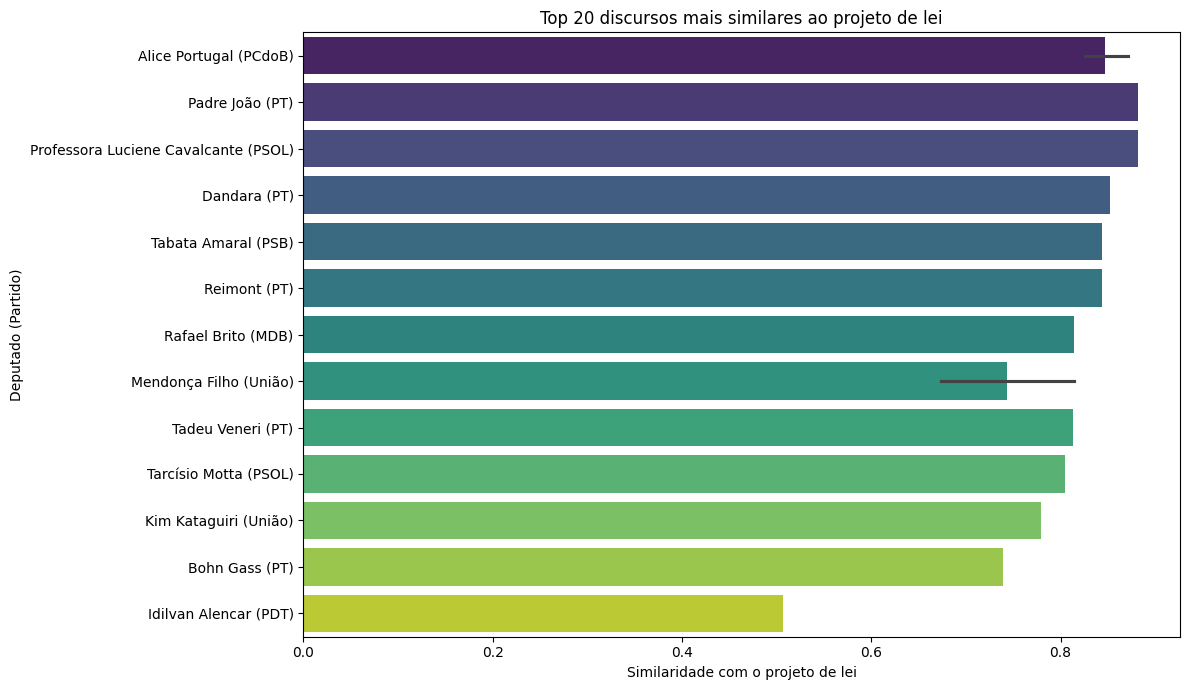

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar os discursos por maior similaridade
df_plot = df_discursos.sort_values("sim_lei_2017", ascending=False).copy()

# Criar coluna de rótulo (nome + partido)
df_plot["deputado_partido"] = df_plot["nomeDeputado"] + " (" + df_plot["siglaPartido"] + ")"

# Plotar os 20 primeiros
plt.figure(figsize=(12, 7))
sns.barplot(
    y="deputado_partido",
    x="sim_lei_2017",
    data=df_plot.head(20),
    palette="viridis"
)
plt.title("Top 20 discursos mais similares ao projeto de lei")
plt.xlabel("Similaridade com o projeto de lei")
plt.ylabel("Deputado (Partido)")
plt.tight_layout()
plt.show()

In [23]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [24]:
import json
import pandas as pd

# String JSON fornecida (pode ser substituída por um arquivo JSON real)
 
with open ("Discursos_PLs_Novo_Ensino_Medio_01.json", "r", encoding="utf-8") as texto:

# Carregar JSON para um dicionário Python
    dados = json.load(texto);

# Converter para um DataFrame Pandas
df = pd.DataFrame(dados["data"])

# Exibir as primeiras linhas
print(df.head())



   idEvento   descricaoTipoEvento  idDeputado     nomeDeputado  \
0     70608  Reunião Deliberativa      220598   Tarcísio Motta   
1     71547  Reunião Deliberativa      204533  Idilvan Alencar   
2     71658   Sessão Deliberativa      160538        Bohn Gass   
3     69949  Reunião Deliberativa       74057   Alice Portugal   
4     69945  Reunião Deliberativa       74057   Alice Portugal   

                                         uriDeputado siglaUf  idLegislatura  \
0  https://dadosabertos.camara.leg.br/api/v2/depu...      RJ             57   
1  https://dadosabertos.camara.leg.br/api/v2/depu...      CE             57   
2  https://dadosabertos.camara.leg.br/api/v2/depu...      RS             57   
3  https://dadosabertos.camara.leg.br/api/v2/depu...      BA             57   
4  https://dadosabertos.camara.leg.br/api/v2/depu...      BA             57   

  siglaPartido                                         uriPartido  \
0         PSOL  https://dadosabertos.camara.leg.br/api/v2/p

In [25]:
# Dicionário de classificação política
espectro_politico = {
    "PSOL": "Esquerda",
    "PT": "Esquerda",
    "PCdoB": "Esquerda",
    "PDT": "Centro-Esquerda",
    "PSB": "Centro-Esquerda",
    "MDB": "Centro",
    "PSD": "Centro",
    "PSDB": "Centro-Direita",
    "DEM": "Centro-Direita",
    "PL": "Direita",
    "PP": "Direita",
    "PSC": "Direita",
    "Novo": "Direita",
    "Republicanos": "Direita",
    "União": "Centro-Direita"
}

# Criar uma nova coluna com a classificação política
df["espectro_politico"] = df["siglaPartido"].map(espectro_politico).fillna("Desconhecido")

# Exibir as primeiras linhas com o espectro político
print(df[[ "nomeDeputado", "transcricao" ,"siglaPartido", "espectro_politico"]].head())


      nomeDeputado                                        transcricao  \
0   Tarcísio Motta  O SR. TARCÍSIO MOTTA (Bloco/PSOL - RJ. Sem rev...   
1  Idilvan Alencar  O SR. IDILVAN ALENCAR (Bloco/PDT - CE. Sem rev...   
2        Bohn Gass  O SR. BOHN GASS (Bloco/PT - RS. Sem revisão do...   
3   Alice Portugal  A SRA. ALICE PORTUGAL (Bloco/PCdoB - BA. Sem r...   
4   Alice Portugal  A SRA. ALICE PORTUGAL (Bloco/PCdoB - BA. Sem r...   

  siglaPartido espectro_politico  
0         PSOL          Esquerda  
1          PDT   Centro-Esquerda  
2           PT          Esquerda  
3        PCdoB          Esquerda  
4        PCdoB          Esquerda  


In [26]:
from transformers import AutoTokenizer

# Carregar o tokenizador de um modelo pré-treinado
modelo = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(modelo)
# Carregar o modelo pré-treinado BERT
model = AutoModel.from_pretrained(modelo)

# Tokenizar os textos da coluna "transcricao"
max_length = model.config.max_position_embeddings
tokens = tokenizer(df["transcricao"].tolist(), return_tensors="pt", truncation=True, padding=True, max_length=max_length)

# Exibir os tokens gerados
print(tokens)


{'input_ids': tensor([[  101,   231,   200,  ...,   125,  2388,   102],
        [  101,   231,   200,  ..., 15552,   712,   102],
        [  101,   231,   200,  ...,  4301, 10218,   102],
        ...,
        [  101,   177,   200,  ...,     0,     0,     0],
        [  101,   231,   200,  ..., 15552,   712,   102],
        [  101,   231,   200,  ...,   170,   123,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}


In [27]:
from transformers import AutoModel
import torch


# Passar os tokens pelo modelo para gerar embeddings
with torch.no_grad():
    outputs = model(**tokens)

# Extraindo os embeddings da última camada oculta
embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Adicionar ao DataFrame
df["embedding"] = embeddings.tolist()

# Exibir os embeddings
print(df[["nomeDeputado", "embedding"]])


                     nomeDeputado  \
0                  Tarcísio Motta   
1                 Idilvan Alencar   
2                       Bohn Gass   
3                  Alice Portugal   
4                  Alice Portugal   
5                    Rafael Brito   
6                  Alice Portugal   
7                  Mendonça Filho   
8                         Reimont   
9                         Dandara   
10  Professora Luciene Cavalcante   
11                 Alice Portugal   
12                 Mendonça Filho   
13                     Padre João   
14                  Tabata Amaral   
15                  Kim Kataguiri   
16                 Alice Portugal   
17                  Tabata Amaral   
18                Idilvan Alencar   
19                   Tadeu Veneri   

                                            embedding  
0   [-0.11048069596290588, 0.07776959985494614, 0....  
1   [-0.10577062517404556, -0.011934841051697731, ...  
2   [-0.0627225711941719, 0.07326792180538177, 0.5... 

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

# Comparar a similaridade entre os discursos
similaridade = cosine_similarity([embeddings[0]], [embeddings[1]])

print(f"Similaridade entre os discursos: {similaridade[0][0]:.4f}")


Similaridade entre os discursos: 0.9674


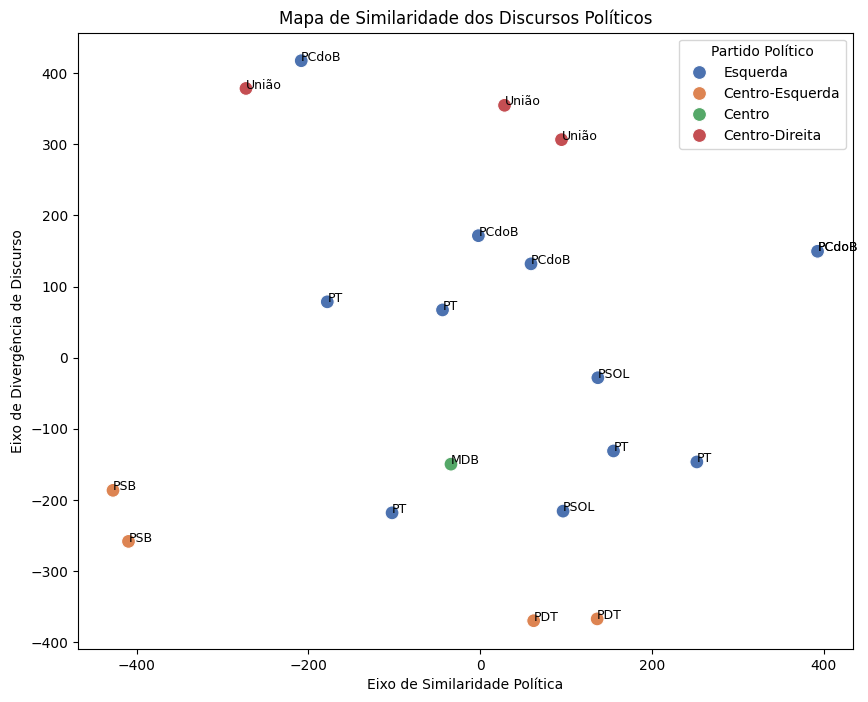

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


# Reduzir a dimensionalidade com t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Adicionar ao DataFrame
df["tsne_x"] = embeddings_2d[:, 0]
df["tsne_y"] = embeddings_2d[:, 1]


plt.figure(figsize=(10, 8))

# Criar gráfico com os discursos posicionados no espaço reduzido
sns.scatterplot(x="tsne_x", y="tsne_y", hue="espectro_politico", data=df, palette="deep", s=100)

# Adicionar rótulos aos pontos (opcional)
for i, row in df.iterrows():
    plt.annotate(row["siglaPartido"], (row["tsne_x"], row["tsne_y"]), fontsize=9)

# Renomear os eixos para refletir o contexto do trabalho
plt.title("Mapa de Similaridade dos Discursos Políticos")
plt.xlabel("Eixo de Similaridade Política")  # Antigo 'Dimensão 1'
plt.ylabel("Eixo de Divergência de Discurso")  # Antigo 'Dimensão 2'

plt.legend(title="Partido Político")
plt.show()



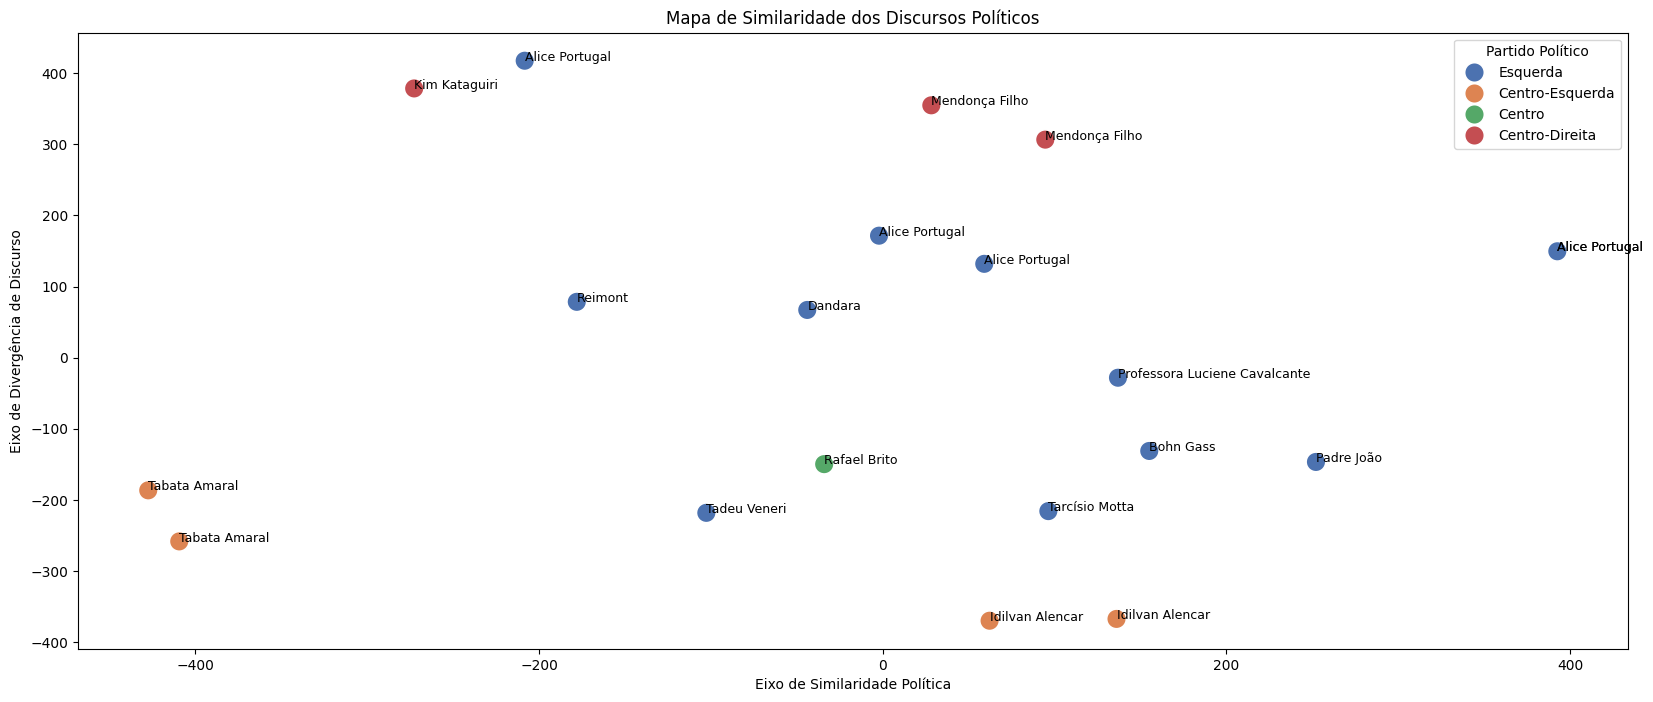

In [30]:
plt.figure(figsize=(20, 8))

# Criar gráfico com os discursos posicionados no espaço reduzido
sns.scatterplot(x="tsne_x", y="tsne_y", hue="espectro_politico", data=df, palette="deep", s=200)

# Adicionar rótulos aos pontos (opcional)
for i, row in df.iterrows():
    plt.annotate(row["nomeDeputado"], (row["tsne_x"], row["tsne_y"]), fontsize=9)

# Renomear os eixos para refletir o contexto do trabalho
plt.title("Mapa de Similaridade dos Discursos Políticos")
plt.xlabel("Eixo de Similaridade Política")  # Antigo 'Dimensão 1'
plt.ylabel("Eixo de Divergência de Discurso")  # Antigo 'Dimensão 2'

plt.legend(title="Partido Político")
plt.show()


Se partidos semelhantes (exemplo: PSOL e PT) ficarem próximos no eixo X, então Dimensão 1 representa ideologia política.
Se houver muita dispersão no eixo Y, pode indicar variação interna dentro dos partidos (discursos mais independentes).

Por aqui, conclui-se as visualizações geradas para o trabalho, e análises podem ser realizadas.

Abaixo estão pedaços de algumas visualizações testes que realizei antes de conseguir chegar na solução acima.

In [31]:
import plotly.figure_factory as ff
import nbformat

print(nbformat.__version__)
# Criar uma tabela com os dados relevantes
tabela = df[["nomeDeputado",  "embedding"]]

# Transformar embeddings em strings reduzidas para exibição
tabela["embedding"] = tabela["embedding"].apply(lambda x: str(x[:5]) + "...")  # Mostra apenas os 5 primeiros valores

# Criando a tabela interativa
fig = ff.create_table(tabela)

# Exibir a tabela
fig.show()

5.10.4


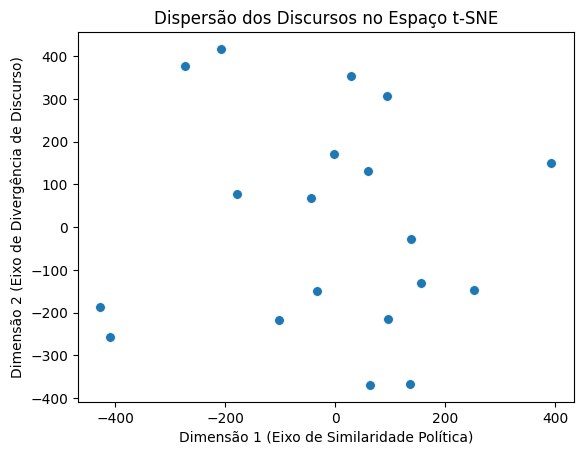

                  tsne_x      tsne_y
siglaPartido                        
MDB           -34.073067 -149.571304
PCdoB         126.765846  203.891449
PDT            99.136169 -368.280579
PSB          -418.463623 -222.234680
PSOL          116.660217 -121.869446
PT             16.526823  -69.999084
União         -49.936890  346.395172


In [32]:
import seaborn as sns

# Criar gráfico de dispersão sem cores
sns.scatterplot(x=df["tsne_x"], y=df["tsne_y"], s=50)
plt.xlabel("Dimensão 1 (Eixo de Similaridade Política)")
plt.ylabel("Dimensão 2 (Eixo de Divergência de Discurso)")
plt.title("Dispersão dos Discursos no Espaço t-SNE")
plt.show()

# Agrupar por partido e ver a média das dimensões
df_grouped = df.groupby("siglaPartido")[["tsne_x", "tsne_y"]].mean()
print(df_grouped)
